In [5]:
import os

os.environ['ARCHITECTURE'] = 'convnext'

In [6]:
from ray.tune import ResultGrid, ExperimentAnalysis, Result
from landnet.config import MODELS_DIR, FIGURES_DIR, PROCESSED_DATA_DIR
from landnet.modelling.tune import MetricSorter
from landnet.modelling.classification.inference import InferTrainTest
from landnet.modelling.classification.stats import (
    BinaryClassificationMetricCollection,
)
from landnet.features.tiles import TileConfig, TileSize
from landnet.enums import GeomorphometricalVariable, Mode
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import geopandas as gpd
import numpy as np
import torch
from collections import defaultdict
import re

In [7]:
TRIAL_NAME = 'convnext_100x100'
# TRIAL_NAME = 'convnext_100x100_20epochs'
METRIC = MetricSorter('val_f2_score', 'max')

In [8]:
REGEX = re.compile(r'\d+\.\d*')


def get_value_from_tensor_string(tensor_as_string: str):
    try:
        return float(REGEX.search(tensor_as_string).group(0))
    except:
        return float(tensor_as_string)


def fix_missing_predictions(
    trial_dir: Path,
    variables: list[GeomorphometricalVariable],
    best_checkpoint_path: Path,
):
    infer = InferTrainTest(variables=variables, out_dir=trial_dir)
    tune_space = {
        'batch_size': 4,
        'tile_config': TileConfig(TileSize(100, 100), overlap=0),
    }
    infer.handle_checkpoint(best_checkpoint_path, tune_space)


def get_results_from_checkpoint_dir(checkpoint_dir: Path):
    predictions = checkpoint_dir.parent / 'predictions'

    all_metrics = {}
    map_ = {Mode.VALIDATION: 'val'}
    for mode in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
        metrics = pd.read_csv(
            predictions / mode.value / 'metrics.csv', index_col=0
        )
        metrics = (
            metrics.map(get_value_from_tensor_string).astype(float).iloc[:, 0]
        )
        metrics.index = map_.get(mode, mode.value) + '_' + metrics.index
        all_metrics.update(metrics.to_dict())
    return all_metrics


def parse_variables_from_config(config_path: Path):
    with open(config_path, 'r') as f:
        config = f.read()
    variables = []
    for var in GeomorphometricalVariable:
        if str(var) in config:
            variables.append(var)
    return variables

In [9]:
experiments = []
experiments_dir = MODELS_DIR / TRIAL_NAME
best_result_paths = []
for experiment_dir in experiments_dir.iterdir():
    if not experiment_dir.is_dir():
        continue
    dirs = [file for file in experiment_dir.iterdir() if file.is_dir()]
    if len(dirs) > 1:
        raise Exception

    experiment = ExperimentAnalysis(
        dirs[0], default_metric=METRIC.metric, default_mode=METRIC.mode
    )
    experiment_df = experiment.dataframe(METRIC.metric, mode=METRIC.mode)
    best_result = experiment.best_result.copy()
    best_result['variable'] = experiment_dir.stem
    best_result_path = Path(
        ResultGrid(experiment)
        .get_best_result(metric=METRIC.metric, mode=METRIC.mode)
        .path
    )
    best_result_paths.append(best_result_path)
    best_checkpoint_path = Path(experiment.best_checkpoint.path)
    variables = parse_variables_from_config(
        Path(experiment.experiment_path) / 'geomorphometrical_variables'
    )
    if not (best_result_path / 'predictions' / 'validation').exists():
        assert best_checkpoint_path
        fix_missing_predictions(
            best_result_path,
            variables,
            best_checkpoint_path / 'checkpoint.ckpt',
        )
        print('missing for', best_result_path)
    best_result.update(get_results_from_checkpoint_dir(best_checkpoint_path))
    best_result.update(best_result['config']['train_loop_config'])
    experiments.append(best_result)
experiments = pd.DataFrame(experiments)
# experiments.to_csv(experiments_dir / 'results.csv')

In [6]:
experiment_df.sort_values('val_f2_score').iloc[-1]

train_loss                                                                         0.024145
val_loss                                                                           0.243365
val_accuracy                                                                       0.938856
val_f1_score                                                                       0.943739
val_f2_score                                                                       0.942712
val_f3_score                                                                        0.94237
val_negative_predictive_value                                                      0.931035
val_positive_predictive_value                                                      0.945455
val_roc_auc                                                                        0.984303
val_sensitivity                                                                    0.942029
val_specificity                                                                 

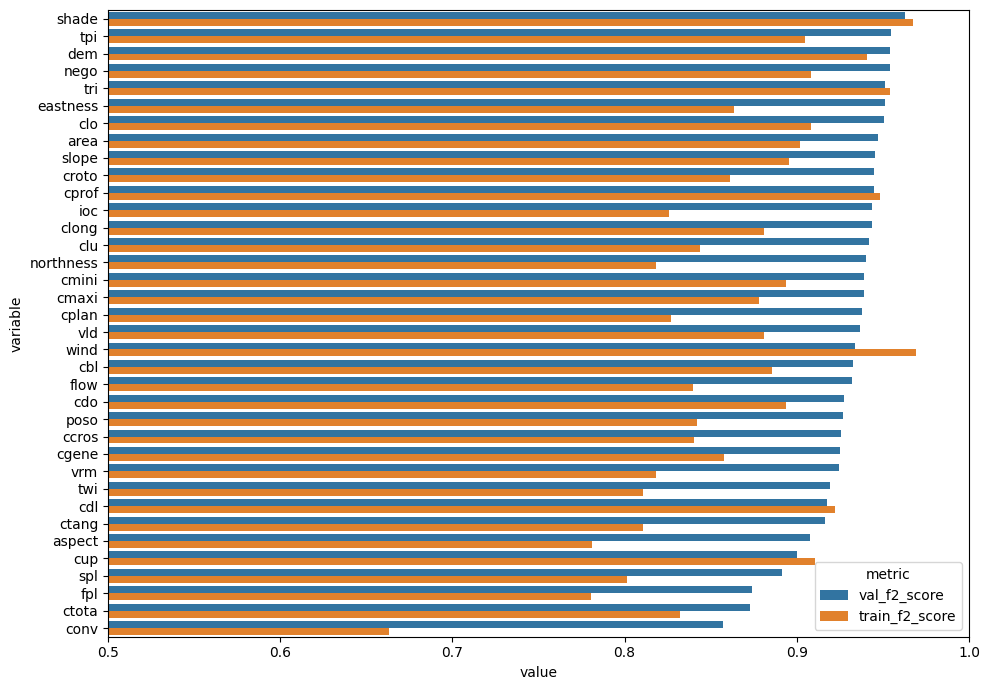

In [48]:
long_df = experiments.melt(
    id_vars='variable',
    value_vars=['val_f2_score', 'train_f2_score'],
    var_name='metric',
    value_name='value',
)
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(
    long_df,
    x='value',
    y='variable',
    hue='metric',
    orient='y',
    ax=ax,
)
ax.set_xlim(0.5, 1)

plt.tight_layout()
# plt.savefig(metrics.parent / 'metrics.png', dpi=300)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


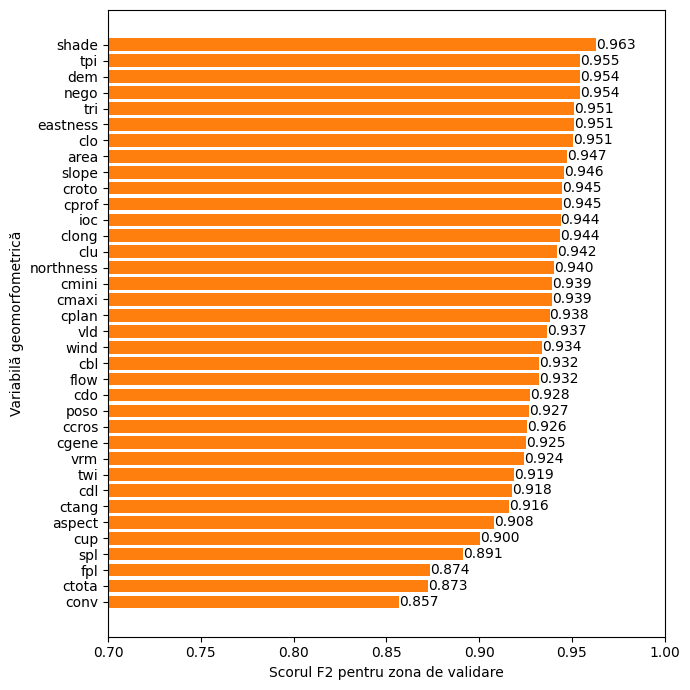

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
experiments = experiments.sort_values(
    ['val_f2_score', 'train_f2_score'], ascending=False
)
sns.barplot(
    experiments,
    x='val_f2_score',
    y='variable',
    orient='y',
    ax=ax,
)
ax.set_xlim(0.7, 1)
ax.set_xlabel('Scorul F2 pentru zona de validare')
ax.set_ylabel('Variabilă geomorfometrică')
# Label with specially formatted floats
y_pos = np.arange(experiments['variable'].shape[0])

hbars = ax.barh(
    y_pos,
    experiments['val_f2_score'].values.flatten(),
    align='center',
)


ax.bar_label(hbars, fmt='%.3f')

plt.tight_layout()
plt.savefig(FIGURES_DIR.parent / 'val_f2_score.png', dpi=300)


# Scores all areas, not just split by train, test, validation

In [10]:
def handle_tiles_directory(directory: Path):
    tiles = gpd.read_file(directory / 'tiles.fgb', inplace=True)
    logits = tiles['logits']
    y = tiles['y']
    return (torch.from_numpy(logits.values), torch.from_numpy(y.values))


def compute_metrics(logits, target):
    metrics = BinaryClassificationMetricCollection()
    metrics.update(logits, target)
    computed = metrics.compute()
    for k, v in computed.items():
        if isinstance(v, torch.Tensor):
            computed[k] = v.item()
    return computed


def handle_directory(directory: Path, mode=None):
    logits = torch.Tensor()
    targets = torch.Tensor()
    for m in (Mode.TRAIN, Mode.TEST, Mode.VALIDATION):
        if mode is not None:
            if m is not mode:
                continue
        vals = handle_tiles_directory(directory / 'predictions' / m.value)
        logits = torch.concatenate([logits, vals[0]])
        targets = torch.concatenate([targets, vals[1]])

    metrics = compute_metrics(logits, targets)
    name = directory.parent.parent.stem
    metrics['name'] = name
    metrics['path'] = directory
    return metrics


convnext_100x100_single = [
    file
    for file in Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100'
    ).iterdir()
    if file.is_dir()
]
convnext_100x100_multidimension = [
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_5vars/convnext_100x100_5vars/2025-06-27_16-46-08/TorchTrainer_05f6ed3b_2_batch_size=2,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-27_17-10-49'
    ),
    Path(
        '/media/alex/alex/python-modules-packages-utils/landnet/models/convnext_100x100_allvars/convnext_100x100_allvars/2025-06-30_05-31-04/TorchTrainer_1ba651e8_5_batch_size=2,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-30_03-56-18'
    ),
]

results = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir)
    results.append(result)
results_df = pd.DataFrame(results)
results_df.set_index('name', inplace=True)
results_train = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir, Mode.TRAIN)
    results_train.append(result)
results_train = pd.DataFrame(results_train)
results_train.set_index('name', inplace=True)
results_test = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir, Mode.TEST)
    results_test.append(result)
results_test = pd.DataFrame(results_test)
results_test.set_index('name', inplace=True)
results_validation = []
for dir in itertools.chain(best_result_paths, convnext_100x100_multidimension):
    result = handle_directory(dir, Mode.VALIDATION)
    results_validation.append(result)
results_validation = pd.DataFrame(results_validation)
results_validation.set_index('name', inplace=True)

/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option INPLACE
  return ogr_read(
/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option INPLACE
  return ogr_read(
/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option INPLACE
  return ogr_read(
/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option INPLACE
  return ogr_read(
/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not support open option INPLACE
  return ogr_read(
/home/alex/miniforge3/envs/landnet/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver FlatGeobuf does not sup

In [11]:
if 'f2_score_train' not in results_test.columns:
    results_test = results_test.merge(
        results_train,
        left_index=True,
        right_index=True,
        suffixes=(None, '_train'),
    )
results_test = results_test.sort_values(
    by=['f2_score', 'f2_score_train'],
    ascending=False,
)
results_test.to_csv(PROCESSED_DATA_DIR / 'results_for_test_areas.csv')

In [12]:
results_train = results_train.sort_values(
    by=['f2_score', 'sensitivity'],
    ascending=False,
)
results_train.to_csv(PROCESSED_DATA_DIR / 'results_for_train_areas.csv')

In [13]:
results_validation = results_validation.sort_values(
    by=['f2_score', 'sensitivity'],
    ascending=False,
)
results_validation.to_csv(
    PROCESSED_DATA_DIR / 'results_for_validation_areas.csv'
)

In [ ]:
if 'f2_score_test' not in results_df.columns:
    results_df = results_df.merge(
        results_train,
        left_index=True,
        right_index=True,
        suffixes=(None, '_test'),
    )
results_df = results_df.sort_values(
    by=['f2_score', 'f2_score_test'],
    ascending=False,
)
results_df.to_csv(PROCESSED_DATA_DIR / 'results_for_all_areas.csv')